In [2]:
import pandas as pd
import numpy as np
import sklearn
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from mpl_toolkits.basemap import Basemap
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

In [4]:
query_string1 = '''
                select * from merged order by pickup_datetime asc
'''

In [5]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaximergeddb.sqlite')
# Confirm data is being returned from this query
df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
df = df.drop('index', axis=1)
# Let's filter down to Rate codes 1, 2 and 3 - NYC and its surrounding airports.
taxidf = df.copy()
taxidf = taxidf[taxidf.rate_code < 4]
taxidf.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947,CSH,5.5,0.5,0.5,0.00,0.0,6.50
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271,CRD,14.5,0.5,0.5,2.00,0.0,17.50
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272,CRD,4.0,0.5,0.5,1.00,0.0,6.00
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572,CRD,7.5,0.5,0.5,1.11,0.0,9.61
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791,CSH,7.5,0.5,0.5,0.00,0.0,8.50


## Using a regression model to predict tips
---

In [6]:
taxidf['tip_percentage'] = 100.0*taxidf['tip_amount']/taxidf['total_amount']
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0.000000
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,15.492958
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,19.047619
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,15.789474


In [8]:
print "Summary: Tip percentage\n", taxidf.tip_percentage.describe()

Summary: Tip percentage
count    1.405130e+07
mean     8.085164e+00
std      8.310788e+00
min      0.000000e+00
25%      0.000000e+00
50%      7.692308e+00
75%      1.624365e+01
max      9.600000e+01
Name: tip_percentage, dtype: float64


In [9]:
# Was the driver tipped?
taxidf['with_tip'] = (taxidf.tip_percentage>0)*1

In [13]:
taxidf.pickup_datetime = pd.to_datetime(taxidf.pickup_datetime)

In [14]:
# Day of Week, Hour of Day, Week
import datetime as dt
ref_week = dt.datetime(2013,4,1).isocalendar()[1] # first week of september in 2015
taxidf['Week'] = taxidf.pickup_datetime.apply(lambda x:x.isocalendar()[1])-ref_week+1
taxidf['Week_day']  = taxidf.pickup_datetime.apply(lambda x:x.isocalendar()[2])
taxidf['Month_day'] = taxidf.pickup_datetime.apply(lambda x:x.day)
taxidf['Hour'] = taxidf.pickup_datetime.apply(lambda x:x.hour)
taxidf.head(1)

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Shift_type,Week,Week_day,Month_day,Hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.4,-73.9935,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667,1,NaN,1,1,1,0


In [15]:
# create shift variable:  1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)
taxidf['Shift_type'] = np.NAN
taxidf.loc[taxidf[(taxidf.Hour>=7) & (taxidf.Hour<15)].index,'Shift_type'] = 1
taxidf.loc[taxidf[(taxidf.Hour>=15) & (taxidf.Hour<23)].index,'Shift_type'] = 2
taxidf.loc[taxidf[taxidf.Shift_type.isnull()].index,'Shift_type'] = 3
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Shift_type,Week,Week_day,Month_day,Hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667,1,3.0,1,1,1,0
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0.000000,0,3.0,1,1,1,0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,15.492958,1,3.0,1,1,1,0
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,19.047619,1,3.0,1,1,1,0
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,15.789474,1,3.0,1,1,1,0


In [16]:
# Speed in miles per hour
taxidf['speed'] = taxidf.trip_distance/(taxidf.trip_time_in_secs/3600.)
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tip_percentage,with_tip,Shift_type,Week,Week_day,Month_day,Hour,speed
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,16.666667,1,3.0,1,1,1,0,19.367089
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0.000000,0,3.0,1,1,1,0,17.640000
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,15.492958,1,3.0,1,1,1,0,14.550000
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,19.047619,1,3.0,1,1,1,0,16.900000
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,15.789474,1,3.0,1,1,1,0,21.840000


In [17]:
#Filter down to all trips below 200mph
taxidf = taxidf[taxidf['speed'] < 200]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

# Basic Linear Model
y = taxidf.tip_percentage
X = taxidf[['trip_time_in_secs','trip_distance','speed','tip_amount','tolls_amount', 
            'Shift_type', 'Week', 'Week_day', 'Month_day', 'Hour']]

(X_train, X_test, y_train, y_test) = train_test_split(X, y)

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [21]:
ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [22]:
# Print R_squared
print "The R-squared of the RANSAC model is: ", ransac.score(X_test, y_test)
print "The R-squared of the Huber model is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model is: ", ols.score(X_test, y_test)

The R-squared of the RANSAC model is:  0.544172151514
The R-squared of the Huber model is:  0.59960444193
The R-squared of the OLS model is:  0.700515050182


In [23]:
from sklearn.metrics import median_absolute_error, r2_score
print "Using OLS Regression on average our estimate of taxi fare misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our estimate of taxi fares misses by", \
median_absolute_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of taxi fares misses by", \
median_absolute_error(huber.predict(X_test), y_test)

Using OLS Regression on average our estimate of taxi fare misses by 3.53984143138
Using RANSAC Regression on average our estimate of taxi fares misses by 2.4700099643
Using Huber Regression on average our estimate of taxi fares misses by 2.68292269147


Even though the OLS model has the highest R-square, when we score by the median absolute error, the RANSAC regressor performs the best.

In [24]:
ypred_ols = ols.predict(X_test)
ypred_r = ransac.predict(X_test)
ypred_h = huber.predict(X_test)

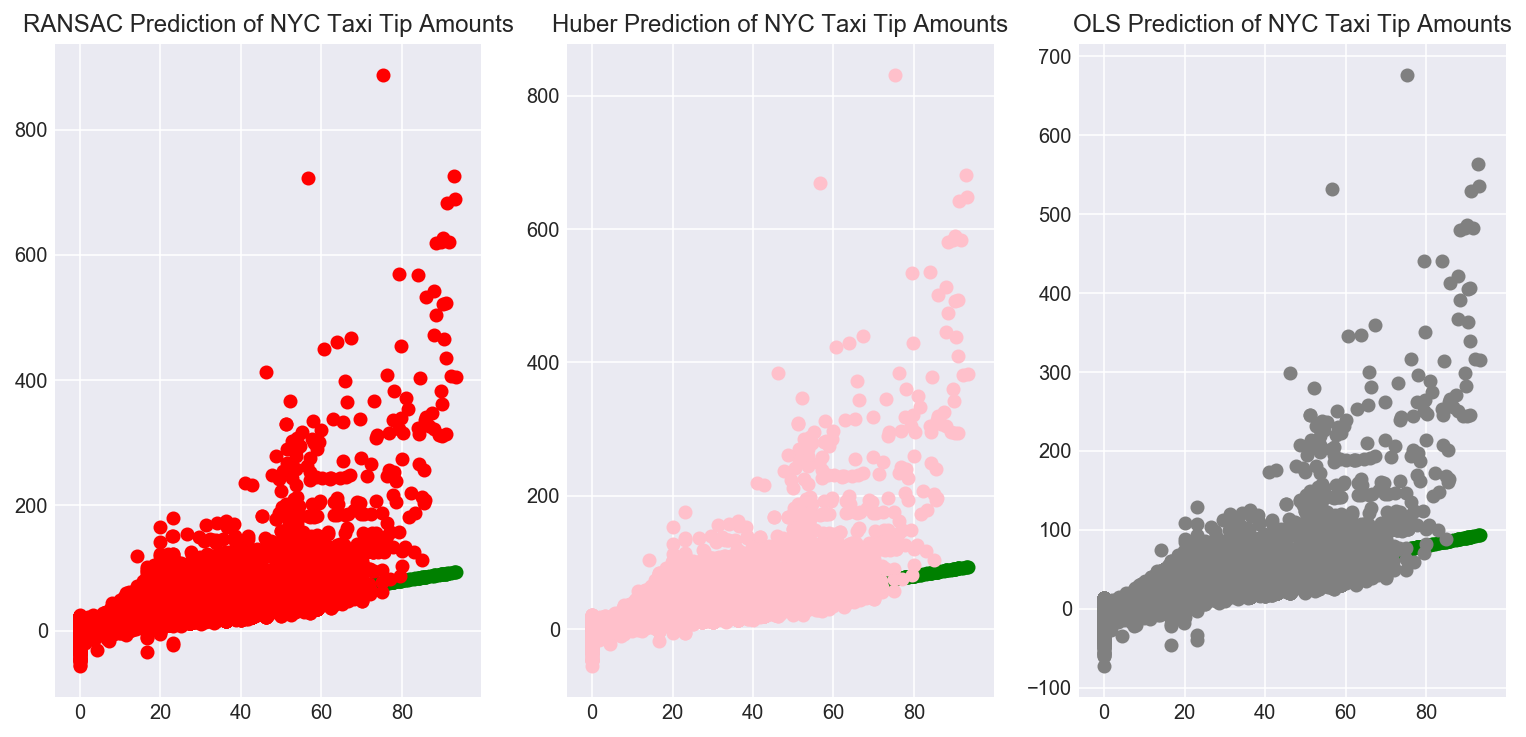

In [25]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(13,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_r, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Tip Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Tip Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Tip Amounts')

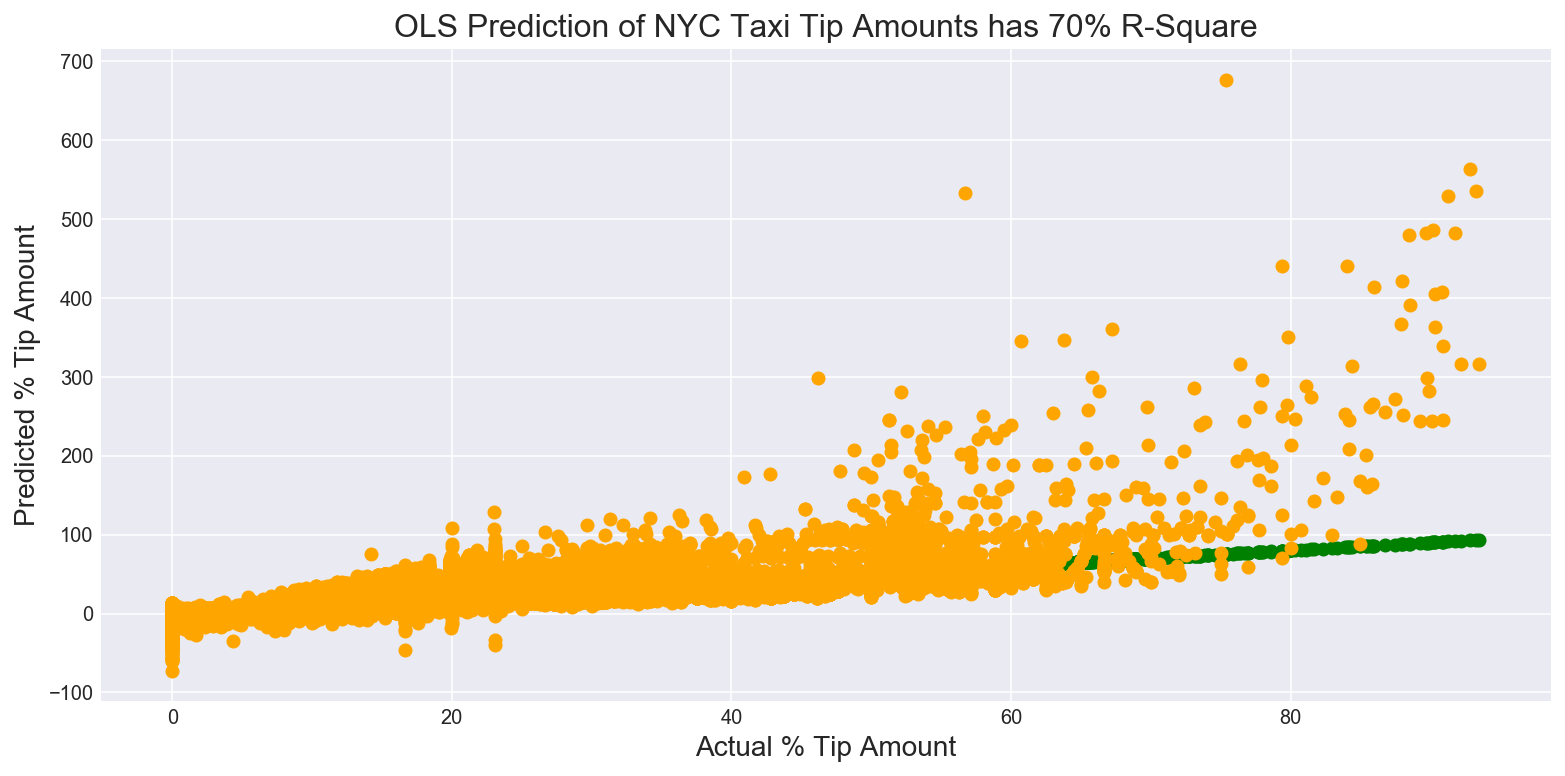

In [30]:
fig, ax = plt.subplots(figsize=(13,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_ols, c='orange')
ax.set_title('OLS Prediction of NYC Taxi Tip Amounts has 70% R-Square', fontsize=16)
ax.set_ylabel('Predicted % Tip Amount', fontsize=14)
ax.set_xlabel('Actual % Tip Amount', fontsize=14)
None

## 5-Fold Cross Validation

In [27]:
ols = LinearRegression()
sklearn.model_selection.cross_val_score(ols, X, y, cv=5)

array([ 0.70497167,  0.69790121,  0.70218642,  0.69559096,  0.68947093])

In [29]:
sklearn.model_selection.cross_val_score(ols, X, y, cv=5).mean()

0.69802423686379278